In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
# Constants
alpha = 0.01
beta = 0.02
k = 1
r = 1
x0 = 20
y0 = 20
T = 15
N = 100
dt = T / N

# Define the system of differential equations
def predator_prey(t, z):
    x, y = z
    dxdt = k * x - alpha * x * y
    dydt = -r * y + beta * x * y
    return [dxdt, dydt]

# RK4 implementation
def rk4(x0, y0, dt, T):
    steps = int(T / dt)
    t = np.linspace(0, T, steps + 1)
    x = np.zeros(steps + 1)
    y = np.zeros(steps + 1)
    x[0], y[0] = x0, y0

    for i in range(steps):
        k1 = predator_prey(t[i], [x[i], y[i]])
        k2 = predator_prey(t[i] + dt/2, [x[i] + dt/2 * k1[0], y[i] + dt/2 * k1[1]])
        k3 = predator_prey(t[i] + dt/2, [x[i] + dt/2 * k2[0], y[i] + dt/2 * k2[1]])
        k4 = predator_prey(t[i] + dt, [x[i] + dt * k3[0], y[i] + dt * k3[1]])
        
        x[i + 1] = x[i] + (dt / 6) * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y[i + 1] = y[i] + (dt / 6) * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])

    return t, x, y

# Trapezoidal rule implementation
def trapezoidal(x0, y0, dt, T):
    N = int(T / dt)
    t = np.linspace(0, T, N + 1)
    x = np.zeros(N + 1)
    y = np.zeros(N + 1)
    x[0], y[0] = x0, y0

    def F(vals, xi, yi):
        xn, yn = vals
        Fx = xn - xi - 0.5 * dt * (predator_prey(t[i], [xi, yi])[0] + predator_prey(t[i+1], [xn, yn])[0])
        Fy = yn - yi - 0.5 * dt * (predator_prey(t[i], [xi, yi])[1] + predator_prey(t[i+1], [xn, yn])[1])
        return np.array([Fx, Fy])

    def jacobian(xi, yi):
        xn, yn = xi, yi
        J = np.array([[k - alpha * yn, -alpha * xn],
                      [beta * yn, -r + beta * xn]])
        return J

    for i in range(N):
        guess = np.array([x[i], y[i]])
        for _ in range(10000):  # Max 100 iterations per time step
            F_val = F(guess, x[i], y[i])
            I_minus_J_val = np.identity(2)-0.5*dt*jacobian(x[i], y[i])
            delta = np.linalg.solve(I_minus_J_val, -F_val)
            guess += delta
            # Prevent overflow by capping the values
            guess = np.clip(guess, -1e20, 1e20)
            if np.linalg.norm(delta) < 1e-6:  # Convergence tolerance
                break
        x[i+1], y[i+1] = guess

    return t, x, y

In [3]:
# Solve using RK4 and Trapezoidal
t_rk4, x_rk4, y_rk4 = rk4(x0, y0, dt, T)
t_trap, x_trap, y_trap = trapezoidal(x0, y0, dt, T)

# Calculate the time points
t_points = np.linspace(0, T, N + 1)

# High precision benchmark solution, using the same time points
benchmark_sol = solve_ivp(predator_prey, [0, T], [20, 20], t_eval=t_points, method='Radau', rtol=1e-10, atol=1e-12)

# Calculate the absolute errors
error_rk4_x = np.abs(benchmark_sol.y[0] - x_rk4)
error_rk4_y = np.abs(benchmark_sol.y[1] - y_rk4)
error_trap_x = np.abs(benchmark_sol.y[0] - x_trap)
error_trap_y = np.abs(benchmark_sol.y[1] - y_trap)

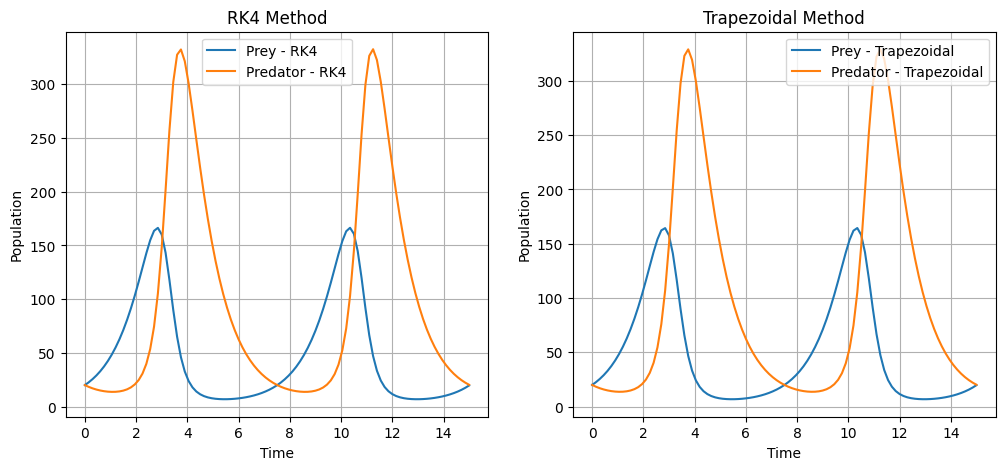

In [4]:
# Plotting the results
# RK4 Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t_rk4, x_rk4, label='Prey - RK4')
plt.plot(t_rk4, y_rk4, label='Predator - RK4')
plt.title('RK4 Method')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

# Trapezoidal Plot
plt.subplot(1, 2, 2)
plt.plot(t_trap, x_trap, label='Prey - Trapezoidal')
plt.plot(t_trap, y_trap, label='Predator - Trapezoidal')
plt.title('Trapezoidal Method')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

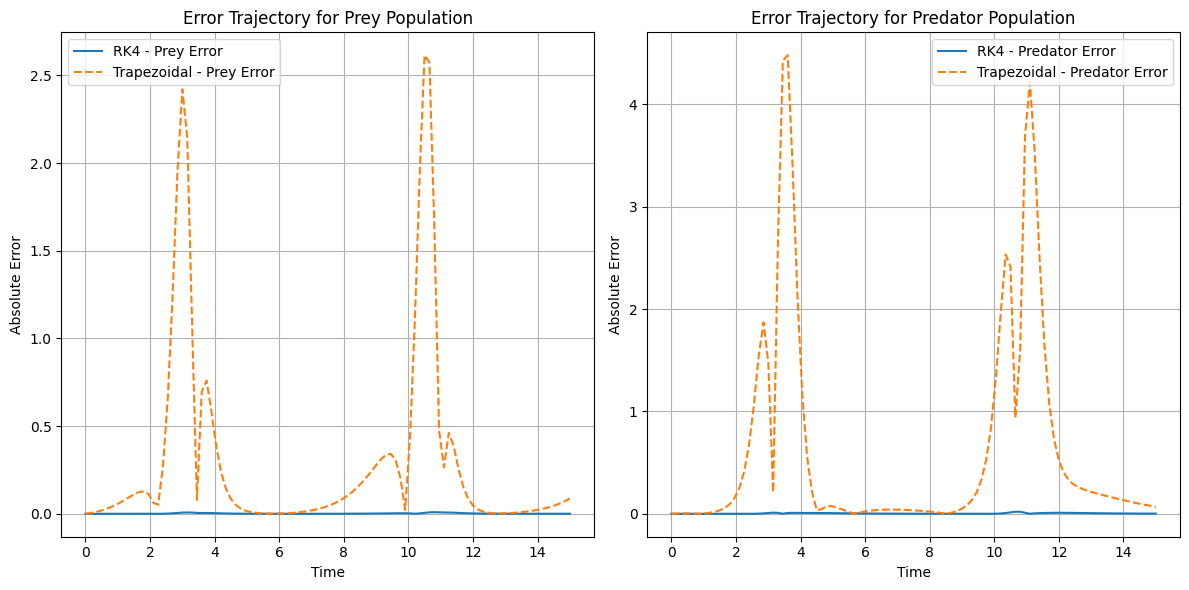

In [5]:
# Plotting the error trajectories
plt.figure(figsize=(12, 6))

# Error in prey population
plt.subplot(1, 2, 1)
plt.plot(t_rk4, error_rk4_x, label='RK4 - Prey Error')
plt.plot(t_rk4, error_trap_x, label='Trapezoidal - Prey Error', linestyle='--')
plt.title('Error Trajectory for Prey Population')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)

# Error in predator population
plt.subplot(1, 2, 2)
plt.plot(t_rk4, error_rk4_y, label='RK4 - Predator Error')
plt.plot(t_rk4, error_trap_y, label='Trapezoidal - Predator Error', linestyle='--')
plt.title('Error Trajectory for Predator Population')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
# Data frame for displaying errors
error_df = pd.DataFrame({
    "Method": ["RK4", "Trapezoidal"],
    "Infinity Norm Error - Prey (x)": [np.max(error_rk4_x), np.max(error_trap_x)],
    "Infinity Norm Error - Predator (y)": [np.max(error_rk4_y), np.max(error_trap_y)]
})

error_df

,Method,Infinity Norm Error - Prey (x),Infinity Norm Error - Predator (y)
0,RK4,0.009139,0.020122
1,Trapezoidal,2.614529,4.479046


In [6]:
# DONE